## Setup

In [1]:
# Check your versions
!python --version;
!pip freeze | grep tensorflow;
!pip freeze | grep pandas;
!pip freeze | grep numpy;
!pip freeze | grep nltk;
!pip freeze | grep gensim;
!pip freeze | grep scikit-learn;

Python 3.7.4
tensorflow==2.0.0
tensorflow-datasets==1.2.0
tensorflow-estimator==2.0.0
tensorflow-gpu==2.0.0
tensorflow-hub==0.6.0
tensorflow-metadata==0.15.0
pandas==0.25.1
numpy==1.17.2
nltk==3.4.5
gensim==3.8.1
scikit-learn==0.21.3


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer

from gensim.models import FastText, Word2Vec
from nltk.util import trigrams, ngrams

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix

import typing
import numbers
import os
import unittest
import random
import copy
import time

### Parameters

In [3]:
# DATA PARAMETERS

min_recall = 0.9 # recall (sensitivity) used for results
splits = 5 # 5 splits means each validation set is 20% of original set, with 80:20 validation:training set ratio
path = Path('data')
checkpoint_path = Path('data/checkpoints')

### Datasets

In [4]:
# Language Model Dataset

file = 'protein_without_selection.csv'

df_lang = pd.read_csv(path/file, usecols=[2],encoding='latin-1')
# df.drop(['Unnamed: 0','id'],axis='columns',inplace=True)

df_lang.columns = ['seq']
mask = (df_lang['seq'].str.len() >= 30) & (df_lang['seq'].str.len() < 302)  # sequences greater than or equal to 30
df_lang = df_lang[mask]
df_lang.drop_duplicates(keep=False, inplace=True)

len(df_lang)

202172

In [5]:
# Classification Set: bacteriocins

file_class1 = 'df_classI_30.csv'
file_class2 = 'df_classII_30.csv'
file_class3 = 'df_classIII_30.csv'

df_c1 = pd.read_csv(path/file_class1, usecols=[1], encoding='latin-1')
df_c2 = pd.read_csv(path/file_class2, usecols=[1], encoding='latin-1')
df_c3 = pd.read_csv(path/file_class3, usecols=[1], encoding='latin-1')

df_pos = pd.concat([df_c1, df_c2, df_c3])
df_pos.columns = ['seq']
mask = (df_pos['seq'].str.len() >= 30) & (df_pos['seq'].str.len() < 302) # sequences greater than or equal to 30
df_pos = df_pos[mask]
df_pos['target'] = 1
df_pos.drop_duplicates(keep='first', inplace=True)

len(df_pos)

550

In [6]:
# min, max lengths of sequences in df_pos
min(len(i) for i in df_pos['seq'].to_numpy()), max(len(i) for i in df_pos['seq'].to_numpy())

(31, 288)

In [7]:
# Classification Set: non-bacteriocins

file_1 = '1.csv'
file_2 = '2.csv'
file_3 = '3.csv'
file_4 = '4.csv'

file_5 = '5.csv'
file_6 = '6.csv'
file_7 = '7.csv'
file_8 = '8.csv'

df_1 = pd.read_csv(path/file_1, usecols=[2], encoding='latin-1')
df_2 = pd.read_csv(path/file_2, usecols=[2], encoding='latin-1')
df_3 = pd.read_csv(path/file_3, usecols=[2], encoding='latin-1')
df_4 = pd.read_csv(path/file_4, usecols=[2], encoding='latin-1')

df_5 = pd.read_csv(path/file_5, usecols=[2], encoding='latin-1')
df_6 = pd.read_csv(path/file_6, usecols=[2], encoding='latin-1')
df_7 = pd.read_csv(path/file_7, usecols=[2], encoding='latin-1')
df_8 = pd.read_csv(path/file_8, usecols=[2], encoding='latin-1')

df_neg = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8])
df_neg.columns = ['seq']
mask = (df_neg['seq'].str.len() >= 30) & (df_neg['seq'].str.len() < 352) # sequences greater than or equal to 30
df_neg = df_neg[mask]
df_neg['target'] = 0
df_neg.drop_duplicates(keep='first', inplace=True)

df_neg = df_neg[0:len(df_pos)]


len(df_neg)

550

In [8]:
# min, max lengths of sequences in df_pos
min(len(i) for i in df_neg['seq'].to_numpy()), max(len(i) for i in df_neg['seq'].to_numpy())

(33, 351)

In [9]:
assert len(df_neg) == len(df_pos)

In [10]:
# classification sets
df_clas = pd.concat([df_pos, df_neg])
df_clas = df_clas.iloc[np.random.permutation(len(df_clas))]
df_clas.reset_index(drop=True,inplace=True)

# CREATE SUBSETS: Training & Validation

# Equal length subsets of original dataframe
cut_indices = [int(i*(1/splits)*len(df_clas)) for i in range(0,splits+1)] # indices where df is to be cut
segment_indices = zip(cut_indices[:-1], cut_indices[1:]) # indices for each cut segment
valids = [df_clas[begin:end] for begin,end in segment_indices] # subsets each to be used as validation sets

# Training sets for each validation set in valids
trains = [pd.concat(valids[1:], axis=0)] # (all sets except for valid set 0 in range(splits))
for n in range(1,splits):
    trains += [pd.concat(valids[:n]+valids[n+1:], axis=0)] # (all sets except for valid set n in range(splits))

# Validation and Training Sets to be used initially
validation = valids[0]
training = trains[0]

In [11]:
# ensure df_lang has no overlap with df_clas
df_lang = pd.concat([df_pos.drop(columns='target'), df_neg.drop(columns='target'), df_lang])
df_lang = pd.concat([df_pos.drop(columns='target'), df_neg.drop(columns='target'), df_lang])
df_lang.drop_duplicates(keep=False, inplace=True)

len(df_lang)

201746

In [12]:
# some tests
assert len(valids) == len(trains)
assert len(valids[0])+len(trains[0])==len(df_clas)

assert list(valids[1].index) != list(valids[0].index)
assert list(trains[1].index) != list(trains[0].index)

for i in range(len(valids)):
    assert valids[i].index[0] not in trains[i].index
    assert valids[i].index[-1] not in trains[i].index

In [13]:
df_lang.head()

,seq
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
3,MYQAINPCPQSWYGSPQLEREIVCKMSGAPHYPNYYPVHPNALGGA...
5,MNAKYDTDQGVGRMLFLGTIGLAVVVGGLMAYGYYYDGKTPSSGTS...
6,MRYTVLIALQGALLLLLLIDDGQGQSPYPYPGMPCNSSRQCGLGTC...
7,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...


In [14]:
df_clas.head()

,seq,target
0,MTQSQETEMDTNENIRSNAQDDVIELSVASVETKGVLPIGNEFMGH...,1
1,MAASRRLMKELEEIRKCGMKNFRNIQVDEANLLTWQGLIVPDNPPY...,0
2,MRMSFGLTFKRTAKVHWRANFSQQCSLRSTGLFVPPSPPLDPEKVK...,0
3,MEKQEQTFVSKISEEELKKLAGGYTEVSPQSTIVCVSLRICNWSLR...,1
4,MVKENKFSKIFILMALSFLGLALFSASLQFLPIAHMAKEFGIPAAV...,1


In [15]:
# a mean close to 0.5 for labels indicates a well balanced dataset
validation['target'].describe()['mean'], training['target'].describe()['mean']

(0.4681818181818182, 0.5079545454545454)

In [16]:
# ensure balanced sets (target labels 0 and 1 each make up 45-55% of dataset)
assert abs(validation['target'].describe()['mean']-0.5) < 0.05
assert abs(training['target'].describe()['mean']-0.5) < 0.05

## LANGUAGE MODEL

In [17]:
# USEFUL FUNCTIONS

def make_grams(sent, n=3):
    "splits a sentence into n-grams"
    return " ".join(["".join(seq) for seq in (ngrams(sent,n))])

def make_grams_ordered(sent, n=3):
    "splits a sentence into multiple sequences of ordered ngrams"
    grams = ["".join(seq) for seq in (ngrams(sent,n))] # make a list of joined ngrams from sentence string
    ordered_grams =  list(np.array([[grams[j+i*n] for i in range(len(grams)//n)] for j in range(n)]).flatten()) # order n grams
    return " ".join(ordered_grams) # return ngrams as a string separated by spaces

# def make_text_array(dataframe, n=3, col='seq'):
#     "Takes a dataframe of sequences, returns an array of sentences containing n-grams of those sequences, separated by spaces"
#     # dataframe: pandas dataframe containing aa sequences
#     # n: n-gram value
#     # col: column of dataframe containing sequences
#     return np.array([[" ".join(["".join(i) for i in ngrams(seq,n)])] for seq in dataframe[col].to_numpy()])

def make_text(dataframe, n=3, col='seq'):
    "Takes a dataframe of sequences, returns an array of sentences containing n-grams of those sequences, separated by spaces"
    # dataframe: pandas dataframe containing aa sequences
    # n: n-gram value
    # col: column of dataframe containing sequences
    return [" ".join(["".join(i) for i in ngrams(seq,n)]) for seq in dataframe[col].to_numpy()]

def make_ordered_text(dataframe, n=3, col='seq'):
    "Takes a dataframe of sequences, returns an array of sentences containing ordered n-grams of those sequences, separated by spaces"
    # dataframe: pandas dataframe containing aa sequences
    # n: n-gram value
    # col: column of dataframe containing sequences
    return [make_grams_ordered(seq) for seq in list(dataframe[col].to_numpy().flatten())]

In [18]:
make_grams("MKLIGPTFTNTSTLSNSV")

'MKL KLI LIG IGP GPT PTF TFT FTN TNT NTS TST STL TLS LSN SNS NSV'

In [19]:
make_grams_ordered("MKLIGPTFTNTSTLSNSV")

'MKL IGP TFT NTS TLS KLI GPT FTN TST LSN LIG PTF TNT STL SNS'

In [20]:
df_lang[0:1]['seq'][0]

'MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPSEKGLIVGHFSGIKYKGEKAQASEVDVNKMCCWVSKFKDAMRRYQGIQTCKIPGKVLSDLDAKIKAYNLTVEGVEGFVRYSRVTKQHVAAFLKELRHSKQYENVNLIHYILTDKRVDIQHLEKDLVKDFKALVESAHRMRQGHMINVKYILYQLLKKHGHGPDGPDILTVKTGSKGVLYDDSFRKIYTDLGWKFTPL'

In [21]:
make_ordered_text(df_lang[0:1])

['MAF SAE DVL KEY DRR RRM EAL LLS LYY PND RKL LDY KEW SPP RVQ VEC PKA PVE WNN PPS EKG LIV GHF SGI KYK GEK AQA SEV DVN KMC CWV SKF KDA MRR YQG IQT CKI PGK VLS DLD AKI KAY NLT VEG VEG FVR YSR VTK QHV AAF LKE LRH SKQ YEN VNL IHY ILT DKR VDI QHL EKD LVK DFK ALV ESA HRM RQG HMI NVK YIL YQL LKK HGH GPD GPD ILT VKT GSK GVL YDD SFR KIY TDL GWK AFS AED VLK EYD RRR RME ALL LSL YYP NDR KLL DYK EWS PPR VQV ECP KAP VEW NNP PSE KGL IVG HFS GIK YKG EKA QAS EVD VNK MCC WVS KFK DAM RRY QGI QTC KIP GKV LSD LDA KIK AYN LTV EGV EGF VRY SRV TKQ HVA AFL KEL RHS KQY ENV NLI HYI LTD KRV DIQ HLE KDL VKD FKA LVE SAH RMR QGH MIN VKY ILY QLL KKH GHG PDG PDI LTV KTG SKG VLY DDS FRK IYT DLG WKF FSA EDV LKE YDR RRR MEA LLL SLY YPN DRK LLD YKE WSP PRV QVE CPK APV EWN NPP SEK GLI VGH FSG IKY KGE KAQ ASE VDV NKM CCW VSK FKD AMR RYQ GIQ TCK IPG KVL SDL DAK IKA YNL TVE GVE GFV RYS RVT KQH VAA FLK ELR HSK QYE NVN LIH YIL TDK RVD IQH LEK DLV KDF KAL VES AHR MRQ GHM INV KYI LYQ LLK KHG HGP DGP DIL TVK TGS KGV LYD DSF RKI YT

In [23]:
# TRAIN EMBEDDING

s = time.time()

sentences = (make_grams_ordered(sent).split(" ") for sent in df_lang['seq'].to_numpy())

# emb_model = FastText(size=200, min_count=1, sg=1)  # instantiate
emb_model = Word2Vec(size=200, window=5, min_count=1, sg=1)  # instantiate, sg: skip-gram
emb_model.build_vocab(sentences=sentences, update=False)

sentences = (make_grams_ordered(sent).split(" ") for sent in df_lang['seq'].to_numpy()) # reset the iterator
emb_model.train(sentences=sentences, total_examples=100000, epochs=100)  # train

print(f"Model Training Time: {time.time()-s:.3f} seconds")

Model Training Time: 94.627 seconds


## CLASSIFICATION MODEL

In [24]:
# USEFUL FUNCTIONS

def word2int(words):
    if isinstance(words, str):
        "Takes a string of words and returns a list of corresponding integers"
        seq = tok.texts_to_sequences([words])
        return np.array(seq).flatten().tolist()
    elif isinstance(words, typing.Iterable):
        "Takes a list of strings and returns a list of sequences (lists of corresponding integers)"
        return tok.texts_to_sequences(words)
    else:
        raise ValueError(f'Words were of type {type(words)} but should be either a string or list of strings')
        

def int2word(vec:typing.Iterable[typing.Any]):
    if isinstance(vec[0], numbers.Number):
        "Takes a list of ints and returns a corresponding string"
        return " ".join([list(tok.word_index.keys())[i-1] for i in vec])
    elif isinstance(vec[0], typing.Iterable):
        "Takes an array of sequences (i.e., a 2d array) and returns an array of strings"
        return [int2word(i) for i in vec]
    else:
        raise ValueError( f'Input list should contain either ints or lists of ints, not {type(vec[0])}')

def int2word_no_pad(vec:typing.Iterable[typing.Any]):
    "Removes padding and converts vectors of ints to strings"
    if isinstance(vec[0], numbers.Number):
        "Takes a list of ints and returns a corresponding string"
        return " ".join([list(tok.word_index.keys())[i-1] for i in vec if i != 0])
    elif isinstance(vec[0], typing.Iterable):
        "Takes an array of sequences (i.e., a 2d array) and returns an array of strings"
        return [int2word(i) for i in vec if i != 0]
    else:
        raise ValueError( f'Input list should contain either ints or lists of ints, not {type(vec[0])}')

def show_batch(ds):
    "Takes a tensorflow dataset and returns a batch as a dataframe, with labels shown without padding"
    batch_vecs, batch_targets = next(iter(ds.batch(1)))  # iterate through dataset batches
    batch_vecs, batch_targets = np.array(batch_vecs)[0], np.array(batch_targets)[0]  # convert tf batch to np array & reduce dimension by 1
    return pd.DataFrame(zip(batch_vecs, [int2word_no_pad(arr) for arr in batch_vecs], batch_targets), columns=['encoding','text','target'])


In [25]:
def prediction(seqs, model):
    "Gives a numerical prediction on a sequence using a given model"
    words = [make_grams_ordered(seq) for seq in seqs]
    vecs = word2int(words)
    vecs = tf.keras.preprocessing.sequence.pad_sequences(vecs, maxlen=maxlength, padding='post').astype('uint16')
    return [float(pred) for pred in model.predict(vecs)]

### NETWORK PARAMETERS

In [53]:
# NN PARAMETERS

vocab_size = 8000
emb_dim = 200
maxlength = 302

epochs = 10
batch_size = 64 # 32 # 16 # high batch size used due to time constraints
buffer_size = 100*batch_size

### PREPARE AND TRAIN

In [63]:
runtime = time.time()

# ------------------------------------------
# PREPARE EMBEDDING MATRIX
# ------------------------------------------

embedding_matrix = np.zeros((vocab_size+1, emb_dim))

for i, word in enumerate(list(tok.word_index.keys())):
    if i >= vocab_size:
        break # continue
    if word.upper() in emb_model.wv.vocab:
        embedding_matrix[i] = emb_model.wv[word.upper()] # add embedding vector to matrix



# initialize stuff for ROC curve
tprs, fprs, tprs_interp = [], [], [] # true positive rates, false positive rates
base_fpr = np.linspace(0, 1, 101)
confs = [] # confusion matrices

for fold in range(splits):
    validation = valids[fold]
    training = trains[fold]
    
    traintime = time.time()

    # ------------------------------------------
    # VECTORIZE DATASET
    # ------------------------------------------

    text = make_ordered_text(df_lang[0:10000])

    tok = Tokenizer(num_words=vocab_size, oov_token='<unk>')

    tok.fit_on_texts(text)

    tok.word_index['<pad>'] = 0
    tok.index_word[0] = '<pad>'

    # pad vectors to maxlength
    train_text = make_ordered_text(training)
    train_seqs = tok.texts_to_sequences(train_text)

    # maxlength = max(len(i) for i in train_seqs)

    train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=maxlength, padding='post')

    train_labels = training['target'].to_numpy().flatten()

    # pad vectors to maxlength (don't calculate automatically, or valid set will be of different size)
    valid_text = make_ordered_text(validation)
    valid_seqs = tok.texts_to_sequences(valid_text)
    valid_seqs = tf.keras.preprocessing.sequence.pad_sequences(valid_seqs, maxlen=maxlength, padding='post')

    valid_labels = validation['target'].to_numpy().flatten()


    # Use lowest possible types to speed up training
    train_seqs = train_seqs.astype('uint16')
    valid_seqs = valid_seqs.astype('uint16')
    train_labels = train_labels.astype('bool')
    valid_labels = valid_labels.astype('bool') # uint8 or bool?


    # Convert to TF dataset format
    train_ds = tf.data.Dataset.from_tensor_slices((train_seqs,train_labels))
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_seqs,valid_labels))


    # ------------------------------------------
    # COMPILE MODEL
    # ------------------------------------------

    model = tf.keras.Sequential([
        layers.Embedding(vocab_size+1, emb_dim, weights=[embedding_matrix], input_length=maxlength, trainable=True),
    #     layers.Conv1D(filters=16, kernel_size=3, padding='valid'),
    #     layers.MaxPool1D(),
        layers.Bidirectional(layers.GRU(emb_dim//2,dropout=0.5, recurrent_dropout=0.1, return_sequences=True)),
        layers.Bidirectional(layers.GRU(emb_dim//2,dropout=0.7, recurrent_dropout=0.1, return_sequences=False)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy', # categorical_crossentropy for multilabel classification
                  metrics=['accuracy'])

    # model.summary()


    # ------------------------------------------
    # SHUFFLE AND BATCH DATASETS
    # ------------------------------------------

    train_batch = train_ds.shuffle(buffer_size).batch(batch_size)
    valid_batch = valid_ds.shuffle(buffer_size).batch(batch_size)
    train_prefetch = train_batch.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) # prefetch speeds up training
    valid_prefetch = valid_batch.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


    # ------------------------------------------
    # TRAIN MODEL
    # ------------------------------------------

    history = model.fit(
        train_prefetch,
        epochs=epochs,
        validation_data=valid_prefetch, 
    #     validation_steps=10,
    #     steps_per_epoch=14,
        callbacks = [] # [tf.keras.callbacks.ReduceLROnPlateau()] # cp_callback not used
        )

    # Save Model
    # model.save_weights(str(checkpoint_path)) # save weights


    # ------------------------------------------
    # GET PREDICTIONS
    # ------------------------------------------

    seqs_valid = validation.to_numpy()[:,0]
    targets_valid = validation.to_numpy()[:,1].astype('int')

    preds = prediction(seqs=seqs_valid, model=model)
    preds = np.array(preds).astype('float32')


    # ------------------------------------------
    # ROC CURVE
    # ------------------------------------------

    fpr, tpr, thresholds = metrics.roc_curve(targets_valid, preds, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    tprs += [tpr]
    fprs += [fpr]
    tpr[0] = 0.0
    tprs_interp += [np.interp(base_fpr, fpr, tpr)] # ensure sizes match


    # ------------------------------------------
    # CALCULATE CLASSIFICATION THRESHOLD
    # ------------------------------------------

    precision, recall_val, thresholds = metrics.precision_recall_curve(targets_valid, preds, pos_label=1)
    recall_val = np.asarray(recall_val)
    idx = (np.abs(recall_val - min_recall)).argmin() # Find nearest threshold
    thresh = thresholds[idx]


    # ------------------------------------------
    # OBTAIN CONFUSION MATRIX
    # ------------------------------------------

    predict_label = [1 if pred >= thresh else 0 for pred in preds]
    conf_mat = confusion_matrix(targets_valid, predict_label)
    TN, FP, FN, TP = conf_mat.flatten()

    conf = [TN, FP, FN, TP]
    confs += [conf]

    print(f"\nModel Training Time: {(time.time()-traintime)//60:.0f} minutes {(time.time()-runtime) % 60:.3f} seconds")

print(f"\n Total Training Time: {(time.time()-runtime)//60:.0f} minutes {(time.time()-runtime) % 60:.3f} seconds")

Epoch 1/10
14/14 [==============================] - 15s 1s/step - loss: 0.6553 - accuracy: 0.5875 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
14/14 [==============================] - 10s 743ms/step - loss: 3287851588.3666 - accuracy: 0.6455 - val_loss: 0.6183 - val_accuracy: 0.5955
Epoch 3/10
14/14 [==============================] - 10s 742ms/step - loss: 0.5818 - accuracy: 0.6932 - val_loss: 0.6045 - val_accuracy: 0.6364
Epoch 4/10
14/14 [==============================] - 10s 742ms/step - loss: 0.5547 - accuracy: 0.6932 - val_loss: 0.5722 - val_accuracy: 0.6955
Epoch 5/10
14/14 [==============================] - 10s 745ms/step - loss: 4207051.4029 - accuracy: 0.7398 - val_loss: 0.5387 - val_accuracy: 0.7091
Epoch 6/10
14/14 [==============================] - 10s 744ms/step - loss: 0.4547 - accuracy: 0.7784 - val_loss: 0.4885 - val_accuracy: 0.7500
Epoch 7/10
14/14 [==============================] - 10s 745ms/step - loss: 0.3704 - accuracy: 0.8284 - val_loss: 0.4566 - 

In [77]:
# Save Model
# model.save_weights(str(checkpoint_path)) # save weights

In [74]:
show_batch(valid_prefetch)

,encoding,text,target
0,"[5798, 1095, 1451, 1105, 2436, 941, 2161, 50, ...",mdn kva knv evk kgs ika tfk aav lks ktk vdi gg...,True
1,"[5, 5, 1306, 1068, 2003, 1685, 7903, 3370, 317...",lla lla lay vap ste dsg wcy eiq tkd prs scl gp...,False
2,"[3880, 1143, 5873, 6189, 3913, 911, 3293, 965,...",mda tai her wsv msn asi gqe igv egl tgl dvd al...,True
3,"[1096, 3330, 4588, 4036, 1918, 5213, 1597, 531...",aep rpp hge lqy lgq iqh ilr cgv rkd drt gtg tl...,False
4,"[4425, 1126, 5068, 1286, 2044, 283, 1312, 4440...",mgk tad nhg pvr set are gre nqv ysp vtg arl va...,False
...,...,...,...
59,"[3867, 736, 1784, 2850, 424, 720, 2115, 225, 4...",mnk kni lpq qgq pvi rlt agq lss qla els eea lg...,True
60,"[1589, 1896, 5345, 3820, 1723, 446, 1048, 867,...",gpv lye dpp dqk tsp sgk sat lki csw nvd glr aw...,False
61,"[6259, 1153, 3955, 74, 1478, 2524, 6196, 5600,...",mkm ksi yfi agl llm ivq gsw qnp lqd tee ksr sf...,False
62,"[3105, 2562, 74, 1947, 315, 2626, 2775, 1267, ...",mke iqk agl qee lsi lmd dan nle qlt agi gtt vv...,True


## RESULTS

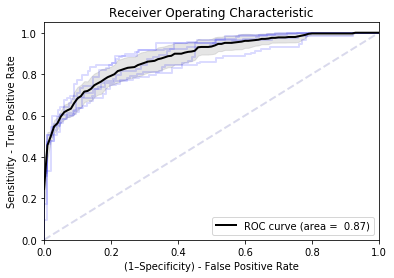

In [64]:
# OVERALL ROC CURVE

# path = Path('data/output')
# img_filename = f'{project_name}_ROC.png'

lw = 2
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.15)
# plt.axes().set_aspect('equal', 'datalim')

for s in range(len(fprs)):
    fpr = fprs[s]
    tpr = tprs[s]
    plt.plot(fpr, tpr, color='blue',lw=lw, alpha=0.14)

mean_tprs = np.array(tprs_interp).mean(axis=0)
std = np.array(tprs_interp).std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'black', lw=2,label=f'ROC curve (area = {roc_auc: 0.2f})')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)


plt.xlabel('(1–Specificity) - False Positive Rate')
plt.ylabel('Sensitivity - True Positive Rate')
plt.title(f'Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# save file
# plt.savefig(path/img_filename, bbox_inches='tight')

plt.show()

In [65]:
confs # confusion matrices for each fold

[[74, 43, 10, 93],
 [75, 28, 12, 105],
 [39, 66, 11, 104],
 [89, 34, 10, 87],
 [56, 46, 12, 106]]

In [70]:
summed_confusion_matrix = np.sum(confs, axis=0)
summed_confusion_matrix

array([333, 217,  55, 495])

In [71]:
# OVERALL RESULTS

results = []
name = 'overall'

results_names = ['dataframe', 'sensitivity', 'specificity', 'accuracy', 'PPV', 'NPV', 'F1', 'odds_ratio', 'TN', 'FP', 'FN', 'TP', 'total']

TN, FP, FN, TP = summed_confusion_matrix

PPV = TP / (TP + FP) if (TP+FP != 0) else 0 # positive predict value
NPV = TN / (TN + FN) if (TN+FN != 0) else 0 # negative predict value
F1 = 2*TP / (2*TP + FP + FN) #
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP /(TP + FN) if (TP+FN != 0) else 0
specificity = TN /(TN + FP) if (TN+FP != 0) else 0
odds_ratio = (TP * TN) /(FP * FN) if (FP*FN != 0) else 0
total = FN+FP+TN+TP

results += [[name, sensitivity, specificity, accuracy, PPV, NPV, F1, odds_ratio, TN, FP, FN, TP, total]]

In [72]:
res_df = pd.DataFrame(data=results, columns=results_names)
res_df

,dataframe,sensitivity,specificity,accuracy,PPV,NPV,F1,odds_ratio,TN,FP,FN,TP,total
0,overall,0.9,0.605455,0.752727,0.695225,0.858247,0.784469,13.81106,333,217,55,495,1100
